# Comparing models visually

_Martin Vonk and Davíd Brakenhoff, Artesia 2022_

---

In this notebook we introduce the `ModelComparison` class in Pastas that can be used to compare models (visually), and construct custom model comparison plots.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pastas as ps

ps.set_log_level("ERROR")
ps.show_versions()


Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
Numpy version: 1.21.2
Scipy version: 1.8.1
Pandas version: 1.4.2
Pastas version: 0.22.0b
Matplotlib version: 3.5.1


## Load Time Series

First load some data to construct models that we can compare with one another.

In [2]:
rain = pd.read_csv(
    "./data/rain_nb1.csv", index_col=0, parse_dates=True
).squeeze()
evap = pd.read_csv(
    "./data/evap_nb1.csv", index_col=0, parse_dates=True
).squeeze()
obs1 = pd.read_csv(
    "./data/head_nb1.csv", index_col=0, parse_dates=True
).squeeze()
obs2 = pd.read_csv(
    "./data/nb18_head.csv", index_col=0, parse_dates=True
).squeeze()


# Create models

* Model1a: observations series 1 with linear RechargeModel and Exponential response function
* Model1b: observations series 1 with linear RechargeModel and Gamma response function
* Model1c: observation series 1 with precipitation and evaporation as separate stresses
* Model2: has observation series 2 with linear RechargeModel and Exponential response function

In [3]:
ml1a = ps.Model(obs1, name="1a_exp")
sm1a = ps.RechargeModel(rain, evap, rfunc=ps.Exponential, name="recharge")
ml1a.add_stressmodel(sm1a)
ml1a.solve(report=False, noise=True)

ml1b = ps.Model(obs1, name="1b_gamma")
sm1b = ps.RechargeModel(rain, evap, rfunc=ps.Gamma, name="recharge")
ml1b.add_stressmodel(sm1b)
ml1b.solve(report=False, noise=True)

ml1c = ps.Model(obs1, name="1c_separate")
sm2_1 = ps.StressModel(rain, rfunc=ps.Gamma, name="Prec", settings="prec")
sm2_2 = ps.StressModel(
    evap, rfunc=ps.Gamma, name="Evap", settings="evap", up=False
)
ml1c.add_stressmodel([sm2_1, sm2_2])
ml1c.solve(report=False, noise=True)

ml2 = ps.Model(obs2, name="model_2")
ml2.add_stressmodel(sm1a)
ml2.solve(report=False, noise=True)


## ModelComparison

To compare models, just pass a list of models to `ps.ModelComparison`. To plot
the default comparison plot use the `plot()` method. 

The class itself is linked to a figure and a set of axes, so for each
comparison a new ModelComparison class should be created.

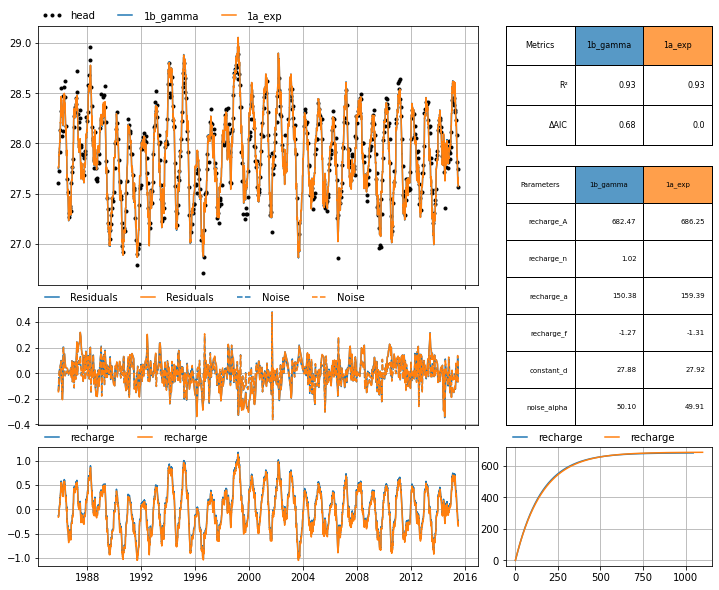

In [4]:
mc = ps.ModelComparison(models=[ml1b, ml1a])
mc.plot()

The layout of the plot is controlled by a so-called mosaic, which is
essentially a 2D array with labels that define the positions of the axes. The
mosaic for the plot above can be accessed through the `mc.mosaic` attribute.
The oseries and model simulations are plotted in the "sim" axes which covers a
2x2 region at the top left of the figure.

In [5]:
mc.mosaic

[['sim', 'sim', 'met'],
 ['sim', 'sim', 'tab'],
 ['res', 'res', 'tab'],
 ['con0', 'con0', 'rf0']]

Access to the axes or the figure is available through `mc.axes` dictionary (e.g. for modifying axes labels, limits, or ticks) or `mc.figure`
(e.g. for saving the figure).

In [6]:
# access the axes dictionary
mc.axes

{'sim': <AxesSubplot:label='sim'>,
 'met': <AxesSubplot:label='met'>,
 'tab': <AxesSubplot:label='tab'>,
 'res': <AxesSubplot:label='res'>,
 'con0': <AxesSubplot:label='con0'>,
 'rf0': <AxesSubplot:label='rf0'>}

## Customizing the comparison

Perhaps you want to view all contributions on the same subplot (and the step
responses as well). For this we need to customize the default plot layout and
tell the plotting method we want several stresses to be plotted on the same
axis.

Customizing the layout (mosaic) can either be done manually, by providing a
list of lists with axes labels, or we can modify the default mosaic slightly
with `mc.get_default_mosaic`. By setting the number of stressmodels to 1 in
this method there will be only one row for the contributions and response
functions.

We are now comparing models 1a and 1c (which had "prec" and "evap" as separate
stresses).

In [7]:
# initialize the comparison
mc = ps.ModelComparison(models=[ml1a, ml1c])


In [8]:
# get a custom mosaic by modifying the default mosaic slightly
mosaic = mc.get_default_mosaic(n_stressmodels=1)
mosaic


[['sim', 'sim', 'met'],
 ['sim', 'sim', 'tab'],
 ['res', 'res', 'tab'],
 ['con0', 'con0', 'rf0']]

The default behavior (when no custom mosaic is provided) is shown below. Note
the difference, with 3 rows showing up for plotting stress models.

In [9]:
# default mosaic when no customization is applied
mc.get_default_mosaic()

[['sim', 'sim', 'met'],
 ['sim', 'sim', 'tab'],
 ['res', 'res', 'tab'],
 ['con0', 'con0', 'rf0'],
 ['con1', 'con1', 'rf1'],
 ['con2', 'con2', 'rf2']]

In order to force the `plot()` method to plot all stressmodels on the same axes
we have to pass it some extra information. This extra information is given as
the `smdict` and is a dictionary that contains an integer index as a key (i.e,
0, 1, ...) and a list of stress model names as its value. The following
dictionary tells `ModelComparison` to combine any stress models with names
"recharge", "Prec" or "Evap" from any model in the comparison list on the first
row (with index 0).

In [10]:
smdict = {0: ["recharge", "Prec", "Evap"]}

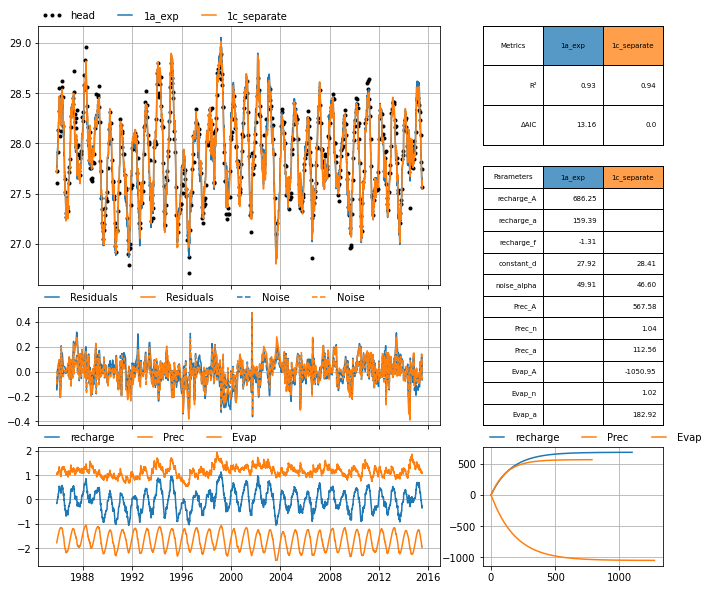

In [11]:
# initialize the figure with our custom mosaic
mc.initialize_figure(mosaic=mosaic)

# now plot the model comparison
mc.plot(smdict=smdict)


## Using individual plotting methods

Each component (i.e. time series or table) in the plots above is controlled by a separate method, making it easy to plot certain components separately. Check out all the methods starting with `plot_*` to see which options are available. When one of these methods is called separately after creating a `ModelComparison` object, a single axis object is created on which the time series for each model are shown. 

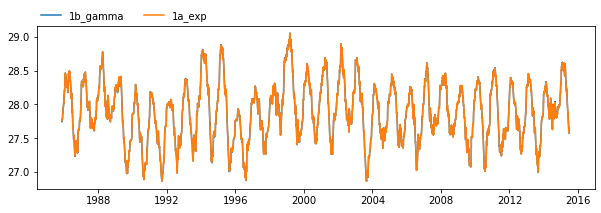

In [12]:
# compare model simulations
mc = ps.ModelComparison(models=[ml1b, ml1a])
mc.plot_simulation()
mc.axes["sim"].legend(loc=(0, 1), frameon=False, ncol=2)


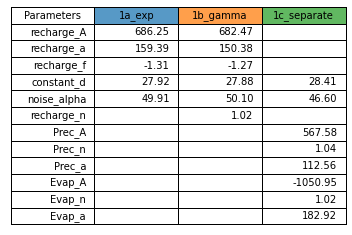

In [13]:
# compare model optimal parameters
mc = ps.ModelComparison(models=[ml1a, ml1b, ml1c])
mc.plot_table_params()


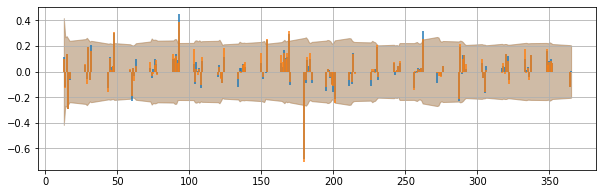

In [14]:
# compare ACF plots
mc = ps.ModelComparison(models=[ml1a, ml1c])
mc.plot_acf()
mc.axes["acf"].grid(True)


## Some helper functions

The `ps.ModelComparison` class contains some helper methods to obtain
information from the models passed to the class. Using these can be especially
useful to customize the tables you wish to show on your comparison figure.

In [15]:
# get minimum tmin and maximum tmax
mc.get_tmin_tmax()


,tmin,tmax
1a_exp,1985-11-14,2015-06-28
1c_separate,1985-11-14,2015-06-28


In [16]:
# get table with all parameters
mc.get_parameters()


,1a_exp,1c_separate
recharge_A,686.248605,NaN
recharge_a,159.386071,NaN
recharge_f,-1.305318,NaN
constant_d,27.920087,28.413801
noise_alpha,49.911926,46.604614
Prec_A,NaN,567.580798
Prec_n,NaN,1.035399
Prec_a,NaN,112.562046
Evap_A,NaN,-1050.945943
Evap_n,NaN,1.023040


In [17]:
# get table with parameters selected by substring
mc.get_parameters(param_selection=["_A"])


,1a_exp,1c_separate
Evap_A,NaN,-1050.945943
Prec_A,NaN,567.580798
recharge_A,686.248605,NaN


In [18]:
# get table with all p-values of statistical tests
mc.get_diagnostics()


,1a_exp,1c_separate
Shapiroo,0.00,0.00
D'Agostino,0.00,0.00
Runs test,0.64,0.08
Stoffer-Toloi,0.08,0.04


In [19]:
# get table with fit metrics
mc.get_metrics()


,1a_exp,1c_separate
rmse,0.114420,0.108872
rmsn,0.079585,0.078664
sse,8.431178,7.633367
mae,0.090044,0.083524
nse,0.929135,0.935841
evp,92.913572,93.584991
rsq,0.929135,0.935841
bic,-3235.196179,-3234.949506
aic,-3257.534672,-3270.691096


## Equal vertical scaling between subplots

It is possible set the vertical scale equal for all the subplots. Just
initialize the figure with `initialize_adjust_height_figure()` instead of
`initialize_figure()`. Note that this does require the default naming
convention for the mosaic to be used (i.e. axes labels must include `"sim"`,
`"res"` and `"con*"`).

*__Note:__ the scaling is not perfect, probably because space taken up by the
xticklabels, the legend and perhaps some other unknown quantities are not taken
into consideration in the calculations, causing some small differences in the
y-scales per subplot.*

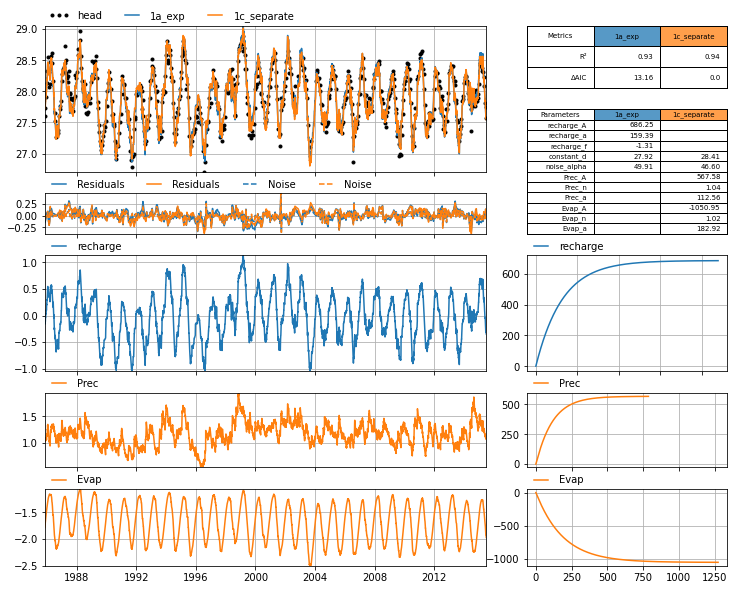

In [20]:
mc = ps.ModelComparison(models=[ml1a, ml1c])
mc.plot(adjust_height=True)

If you want to customize the figure yourself and use the adjusted height functionality, make sure that you provide the `smdict` to the `initialize_adjust_height_figure()` method. Keep in mind that only the first column of the mosaic is used for scaling.

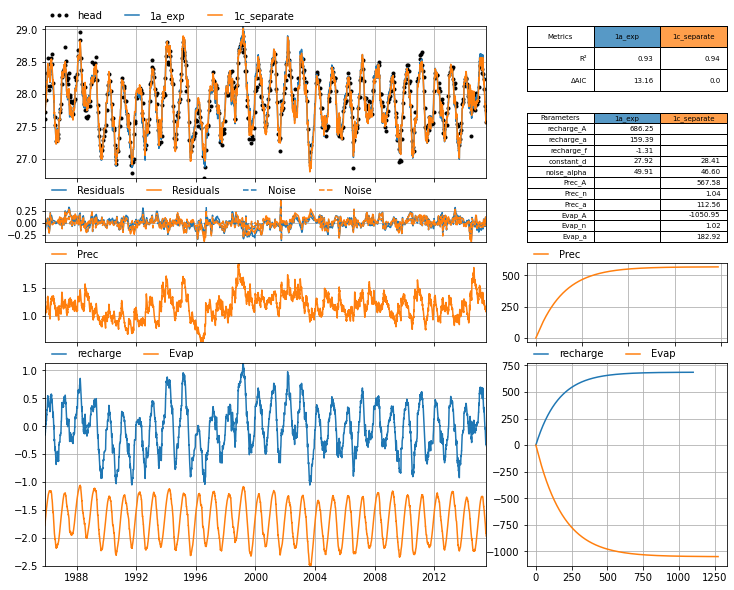

In [21]:
mosaic = [
    ["sim", "sim", "met"],
    ["sim", "sim", "tab"],
    ["res", "res", "tab"], 
    ["con0", "con0", "rf0"],
    ["con1", "con1", "rf1"],
]

smdict={0: ["Prec"], 1: [ "recharge", "Evap"]}

mc = ps.ModelComparison([ml1a, ml1c])
mc.initialize_adjust_height_figure(mosaic=mosaic, smdict=smdict)
mc.plot(legend=True)

## Going a bit overboard

Just to show you what is possible, here is an extreme example in which we do
the following:

- compare 2 models that are related (ml1a and ml1c with the same oseries), and 
  one that isn't (ml2)
- create a custom mosaic by manually providing one
- plot just about every comparison we can think of
- combine all the contributions of the different stresses on the same subplot
- manually share the x-axes between certain plots
- choose a different qualitative colormap

Note that this comparison doesn't make all that much sense, but it does show
you how easy it is to create custom comparison plots.

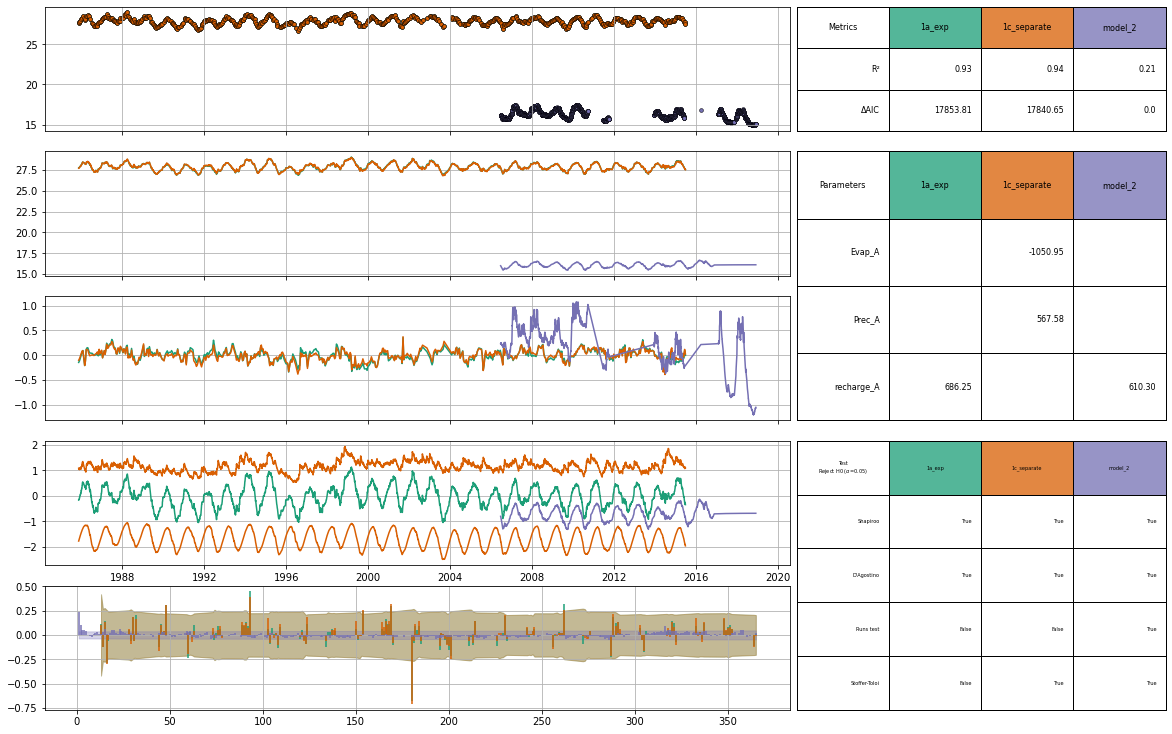

In [22]:
mosaic = [
    ["ose", "ose", "met"],
    ["sim", "sim", "tab"],
    ["res", "res", "tab"],
    ["con0", "con0", "dia"],
    ["acf", "acf", "dia"],
]

mc = ps.ModelComparison(models=[ml1a, ml1c, ml2])
mc.initialize_figure(mosaic, figsize=(16, 10), cmap="Dark2")

# plot oseries on "ose" axis
mc.plot_oseries(axn="ose")

# plot simulation on "sim" axis
mc.plot_simulation()

# plot metrics
mc.plot_table_metrics()

# table of optimal parameters but only those containing the gain "_A"
mc.plot_table_params(param_selection=["_A"])

# plot residuals
mc.plot_residuals()

# plot all contributions on the same axis
mc.plot_contribution(
    smdict={0: ["Prec", "Evap", "Rech", "recharge"]}, axn="con{i}"
)

# plot p-value for diagnostic tests
mc.plot_table_diagnostics(axn="dia", diag_col=r"Reject H0 ($\alpha$=0.05)")

# plot ACF
mc.plot_acf(axn="acf")

# turn grid on
for axlbl in mc.axes:
    mc.axes[axlbl].grid(True)

# share x-axes between plots
mc.share_xaxes(
    [mc.axes["ose"], mc.axes["sim"], mc.axes["res"], mc.axes["con0"]]
)

# set tight layout
mc.figure.tight_layout(pad=0.0)
